# Check GPU


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/natural-language-processing")


Mounted at /content/drive


In [ ]:
!nvidia-smi


Wed Feb 26 15:15:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Improved RoBERTa for PCL Detection with Enhanced Preprocessing and Hyperparameter Tuning


In [ ]:
# Check GPU and install dependencies
!pip install simpletransformers tensorboardx nltk transformers tf-keras tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
  Cr

In [ ]:
import logging, random, pandas as pd, torch
from collections import Counter
from ast import literal_eval
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from urllib import request
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from dont_patronize_me import DontPatronizeMe
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from transformers import pipeline
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Set up logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

cuda_available = torch.cuda.is_available()
print('Cuda available? ', cuda_available)

if cuda_available:
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
        print('Found GPU at: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')


Cuda available?  True
Found GPU at: /device:GPU:0


In [ ]:
# Fetch the Don't Patronize Me! data manager module
module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name, 'w') as outf:
    outf.write(f.read().decode('utf-8'))


Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [ ]:
dpm = DontPatronizeMe('./data/train/original_data', './data/train/original_data')
dpm.load_task1()
dpm.load_task2(return_one_hot=True)


Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


#Prepare Training and Dev Set

In [ ]:
# Load paragraph IDs for training and official dev set
trids = pd.read_csv('./data/train/sample_splits/train_semeval_parids-labels.csv')
teids = pd.read_csv('./data/train/sample_splits/dev_semeval_parids-labels.csv')
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

In [ ]:
data = dpm.train_task1_df

In [ ]:
rows = []
for idx in range(len(trids)):
    parid = trids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
trdf1 = pd.DataFrame(rows)

# Prepend the community label as an extra feature to the text
trdf1['text'] = trdf1['community'] + ": " + trdf1['text']

#Downsampling

In [ ]:
# Adjust class balance (for binary Task 1: treat label==1 as positive, label==0 as negative)
# Downsample negatives to get a ~1:3 ratio with the positive (PCL) class.
pcldf = trdf1[trdf1.label == 1]
npos = len(pcldf)
balanced_df = pd.concat([pcldf, trdf1[trdf1.label == 0][:npos * 3]])
balanced_df = shuffle(balanced_df, random_state=42)
print("Balanced training set shape:", balanced_df.shape)


Balanced training set shape: (3176, 4)


# Prepare Official Dev Set


In [ ]:
# Rebuild dev set (Task 1) with extra feature
rows_test = []
for idx in range(len(teids)):
    parid = teids.par_id[idx]
    keyword = data.loc[data.par_id == parid].keyword.values[0]
    text = data.loc[data.par_id == parid].text.values[0]
    label = data.loc[data.par_id == parid].label.values[0]
    rows_test.append({
        'par_id': parid,
        'community': keyword,
        'text': text,
        'label': label
    })
tedf1 = pd.DataFrame(rows_test)

# Prepend community label to text in dev set as well
tedf1['text'] = tedf1['community'] + ": " + tedf1['text']


In [ ]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [ ]:
# Helper function to save predictions
def labels2file(p, outf_path):
    with open(outf_path, 'w') as outf:
        for pi in p:
            outf.write(','.join([str(k) for k in pi]) + '\n')


#AUGMENTATION FUNCTIONS

In [ ]:
# Augmentation: Synonym Replacement (EDA)
def synonym_replacement(text, alpha=0.1):
    words = text.split()
    new_words = []
    for word in words:
        if random.uniform(0, 1) < alpha:
            synonyms = wordnet.synsets(word)
            if synonyms:
                lemmas = synonyms[0].lemma_names()
                if lemmas:
                    new_word = random.choice(lemmas)
                    new_words.append(new_word)
                else:
                    new_words.append(word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


In [ ]:
# Augmentation: Backtranslation (using MarianMT)
translator_en_to_de = pipeline("translation_en_to_de", model="Helsinki-NLP/opus-mt-en-de")
translator_de_to_en = pipeline("translation_de_to_en", model="Helsinki-NLP/opus-mt-de-en")

def backtranslate(text):
    de_text = translator_en_to_de(text)[0]['translation_text']
    en_text = translator_de_to_en(de_text)[0]['translation_text']
    return en_text


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda:0


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Device set to use cuda:0


# Train and Evaluate





In [ ]:
def train_and_eval(balanced_df, tedf1, phase_label="Phase"):
  print(f"\n=== Training/Eval: {phase_label} ===")

  # Compute class weights for binary classification
  classes = np.array([0, 1])
  class_weights = compute_class_weight('balanced', classes=classes, y=balanced_df['label'])
  class_weights = class_weights.tolist()
  print("Class weights:", class_weights)

  # Configure hyperparameters and early stopping options
  task1_model_args = ClassificationArgs(
      num_train_epochs=3,
      learning_rate=2e-5,
      train_batch_size=16,
      evaluate_during_training=True,
      evaluate_during_training_steps=100,  # adjust as needed
      early_stopping_patience=2,
      early_stopping_delta=0.001,
      save_eval_checkpoints=False,
      save_model_every_epoch=False,
      overwrite_output_dir=True,
  )

  # Pass computed weights
  task1_model_args.weight = class_weights

  # Initialize the ClassificationModel with the improved hyperparameters
  task1_model = ClassificationModel(
    "roberta",
    "roberta-base",
    args=task1_model_args,
    num_labels=2,
    use_cuda=cuda_available,
    weight=class_weights
  )
  # Train the model on the improved and augmented training set
  # Split balanced_df into training and evaluation sets (80% train, 20% eval)
  train_df, eval_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

  # Train the model with both training and evaluation data
  task1_model.train_model(train_df[['text', 'label']], eval_df=eval_df[['text', 'label']])
  # Run predictions on the dev set (for evaluation)
  preds_dev, _ = task1_model.predict(tedf1.text.tolist())
  print("Dev set prediction counts:", Counter(preds_dev))

  # Save dev set predictions as dev.txt
  if phase_label=="Final":
    labels2file([[k] for k in preds_dev], 'dev.txt')

  # --- Compute Evaluation Metrics on the Dev Set ---
  true_labels = tedf1['label'].tolist()
  accuracy = accuracy_score(true_labels, preds_dev)
  precision = precision_score(true_labels, preds_dev)
  recall = recall_score(true_labels, preds_dev)
  f1 = f1_score(true_labels, preds_dev)

  print("Dev Set Accuracy:", accuracy)
  print("Dev Set Precision:", precision)
  print("Dev Set Recall:", recall)
  print("Dev Set F1 Score:", f1)
  print("\nClassification Report:\n", classification_report(true_labels, preds_dev))

  # --- Plot Evaluation Metrics as a Bar Chart ---
  metrics = {
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1
  }

  plt.figure(figsize=(8, 6))
  plt.bar(metrics.keys(), metrics.values(), color='skyblue')
  plt.title("Dev Set Evaluation Metrics")
  plt.ylim(0, 1)
  plt.ylabel("Score")
  plt.show()
  return task1_model




=== Training/Eval: A) Baseline ===
Class weights: [0.6666666666666666, 2.0]


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/159 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/159 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 3:   0%|          | 0/159 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Dev set prediction counts: Counter({0: 1719, 1: 375})
Dev Set Accuracy: 0.87774594078319
Dev Set Precision: 0.424
Dev Set Recall: 0.7989949748743719
Dev Set F1 Score: 0.554006968641115

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      1895
           1       0.42      0.80      0.55       199

    accuracy                           0.88      2094
   macro avg       0.70      0.84      0.74      2094
weighted avg       0.92      0.88      0.89      2094



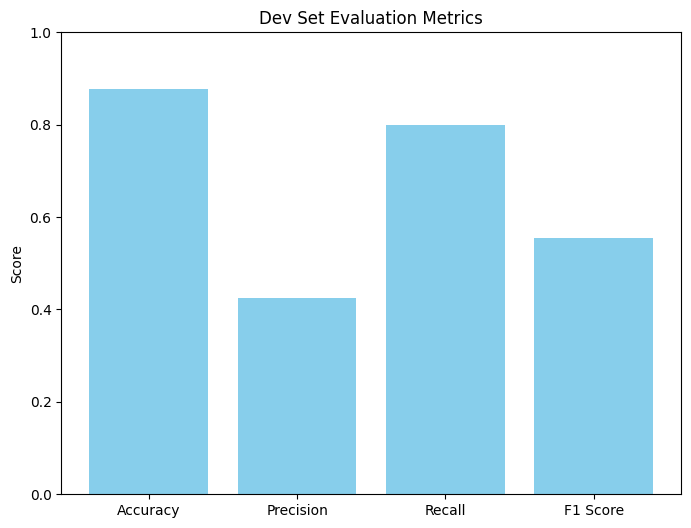

In [ ]:
model_baseline = train_and_eval(balanced_df, tedf1, "A) Baseline")

#Synonym Replacement

After synonym augmentation: (6352, 4)

=== Training/Eval: B) Synonym Replacement ===
Class weights: [0.6666666666666666, 2.0]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/318 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/318 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 3:   0%|          | 0/318 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Dev set prediction counts: Counter({0: 1760, 1: 334})
Dev Set Accuracy: 0.8868194842406877
Dev Set Precision: 0.4431137724550898
Dev Set Recall: 0.7437185929648241
Dev Set F1 Score: 0.5553470919324578

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94      1895
           1       0.44      0.74      0.56       199

    accuracy                           0.89      2094
   macro avg       0.71      0.82      0.75      2094
weighted avg       0.92      0.89      0.90      2094



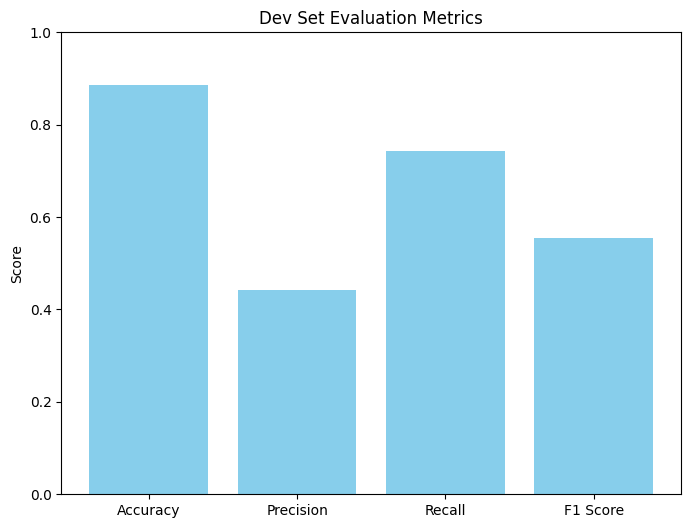

In [ ]:
# Create augmented data by synonym replacement
augmented_rows = []
for idx, row in balanced_df.iterrows():
    new_text = synonym_replacement(row['text'], alpha=0.1)
    augmented_rows.append({
        'par_id': row['par_id'],
        'community': row['community'],
        'text': new_text,
        'label': row['label']
    })
augmented_df = pd.DataFrame(augmented_rows)
balanced_df_syn = pd.concat([balanced_df, augmented_df])
balanced_df_syn = shuffle(balanced_df_syn, random_state=42)
print("After synonym augmentation:", balanced_df_syn.shape)

model_syn = train_and_eval(balanced_df_syn, tedf1, "B) Synonym Replacement")


#Backtranslation

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


After backtranslation augmentation: (7622, 4)

=== Training/Eval: Final ===
Class weights: [0.6649799336939453, 2.0153358011634057]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 3 of 3:   0%|          | 0/382 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Dev set prediction counts: Counter({0: 1789, 1: 305})
Dev Set Accuracy: 0.8968481375358166
Dev Set Precision: 0.4721311475409836
Dev Set Recall: 0.7236180904522613
Dev Set F1 Score: 0.5714285714285714

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      1895
           1       0.47      0.72      0.57       199

    accuracy                           0.90      2094
   macro avg       0.72      0.82      0.76      2094
weighted avg       0.92      0.90      0.91      2094



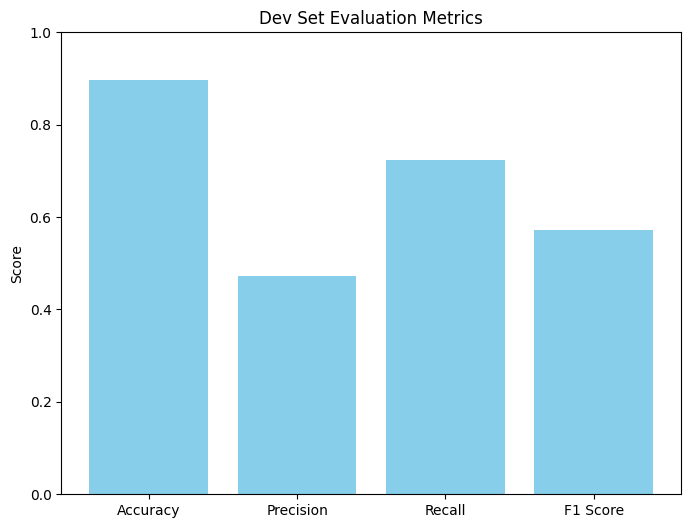

In [ ]:
# Augment a random 20% subset via backtranslation
bt_subset = balanced_df_syn.sample(frac=0.2, random_state=42)
backtranslated_rows = []
for idx, row in bt_subset.iterrows():
    try:
        new_text = backtranslate(row['text'])
        backtranslated_rows.append({
            'par_id': row['par_id'],
            'community': row['community'],
            'text': new_text,
            'label': row['label']
        })
    except Exception as e:
        print("Backtranslation error:", e)
backtranslated_df = pd.DataFrame(backtranslated_rows)
balanced_df_bt = pd.concat([balanced_df_syn, backtranslated_df])
balanced_df_bt = shuffle(balanced_df_bt, random_state=42)
print("After backtranslation augmentation:", balanced_df_bt.shape)

model_final = train_and_eval(balanced_df_bt, tedf1, "Final")
model_final.save_model("./best_model_final")

# Load Official Test Set and Predict (Using task4_test.tsv)


In [ ]:
# Load the official test set (note: no labels available)
official_test_df = pd.read_csv('./data/test.tsv', sep='\t', header=None, names=['text'])
# If necessary, add any preprocessing (e.g., if extra features are needed, modify accordingly)

# Run predictions on the official test set
preds_test, _ = model_final.predict(official_test_df['text'].tolist())
print("Official Test Prediction counts:", Counter(preds_test))

# Save official test set predictions as test.txt
labels2file([[k] for k in preds_test], 'test.txt')


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Official Test Prediction counts: Counter({0: 3308, 1: 524})


# Prepare Submission

In [ ]:
!cat dev.txt | head -n 10
!cat test.txt | head -n 10
!zip submission_improved.zip dev.txt test.txt

0
1
0
1
1
0
1
1
0
1
0
0
0
0
0
1
1
0
0
0
updating: dev.txt (deflated 93%)
updating: test.txt (deflated 93%)
